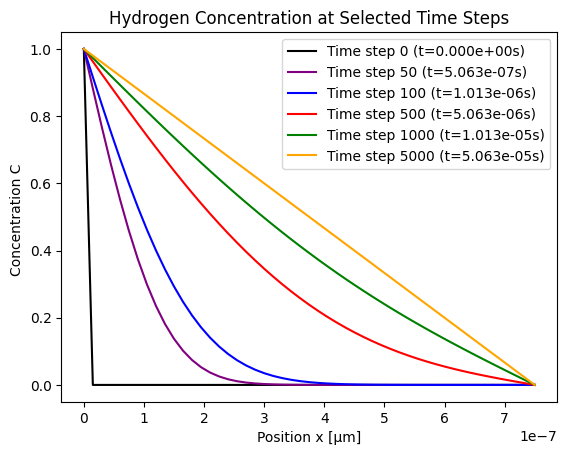

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Define physical parameters ---
L = 0.75e-6      # membrane length [m]
D = 1e-8    # diffusivity [m^2/s]

# --- 2) Define numerical parameters ---
Nx = 51
dx = L / (Nx - 1)
dt = 0.9 * dx**2 / (2*D)  # explicit scheme stability criterion with a safety factor

num_steps = 5000
# dt = 3 * 24 *3/ num_steps
# --- 3) Create the spatial grid ---
x = np.linspace(0, L, Nx)

# --- 4) Initialize the concentration array for all time steps ---
#     We'll store concentration at every time step to facilitate plotting later.
C_time = np.zeros((num_steps + 1, Nx))

# --- 5) Set initial condition (t=0) and boundary conditions ---
C_time[0, :] = 0.0       # initial condition: concentration = 0 everywhere
C_left  = 1.0
C_right = 0.0
C_time[0, 0]  = C_left
C_time[0, -1] = C_right

# --- 6) Time-marching loop ---
for n in range(num_steps):
    # Copy the old time step:
    C_old = C_time[n].copy()
    C_new = C_old.copy()
    
    # Update interior points using the explicit scheme
    for i in range(1, Nx-1):
        C_new[i] = C_old[i] + (D * dt / dx**2) * (C_old[i+1] - 2*C_old[i] + C_old[i-1])
    
    # Reapply boundary conditions
    C_new[0]  = C_left
    C_new[-1] = C_right
    
    # Store the new concentration profile
    C_time[n+1, :] = C_new

# --- 7) Plot the concentration profiles for four different time steps on one figure ---
time_points = [0,50,100, 500, 1000, 5000]  # pick any four (or fewer) steps
colors = ["black","purple","blue", "red", "green", "orange"]  # each profile gets a unique color

plt.figure()
for i, t_step in enumerate(time_points):
    plt.plot(
        x,
        C_time[t_step, :],
        label=f"Time step {t_step} (t={t_step*dt:.3e}s)",
        color=colors[i]  # unique color for each line
    )

plt.xlabel("Position x [µm]")
plt.ylabel("Concentration C ")
plt.title("Hydrogen Concentration at Selected Time Steps")
plt.legend()
plt.show()

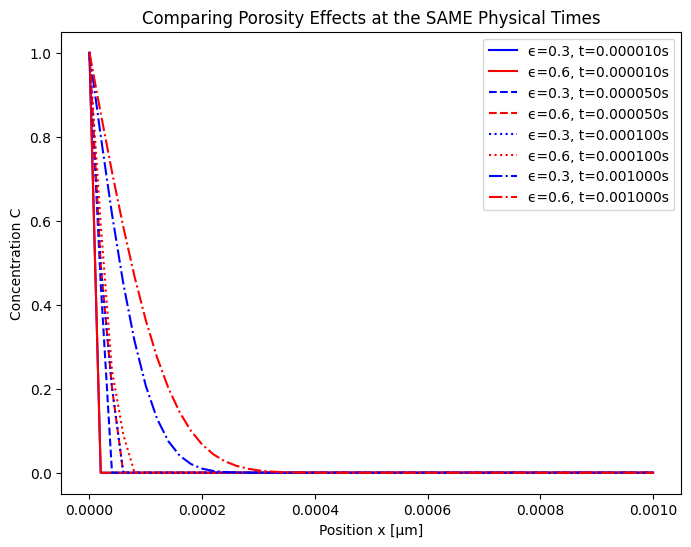

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def run_diffusion(phi, L = 0.75e-6, Nx=51, D=1e-8, T = 300, max_time=2.0):
    """
    1D explicit diffusion with:
        - phi: porosity
        - L:   domain length
        - Nx:  number of spatial points
        - D:   base diffusivity
        - max_time: maximum simulation time (seconds)
    Returns a dictionary with the full time evolution (C_time),
    the computed dt, the array x, and the number of time steps (nsteps).
    """

    # -- 1) Spatial grid --
    x = np.linspace(0, L, Nx)
    dx = x[1] - x[0]

    # -- 2) Effective diffusivity includes porosity --
    D_eff = phi * D  # simple linear scale; you can add more complex formulas if needed

    # -- 3) Stable dt (explicit scheme) and total steps so that we reach max_time --
    dt = 0.9 * dx**2 / (2 * D_eff)
    nsteps = int(np.ceil(max_time / dt))  # number of steps up to 'max_time'

    # -- 4) Prepare concentration array: (nsteps+1) x Nx --
    C_time = np.zeros((nsteps + 1, Nx))

    # -- 5) Boundary and initial conditions --
    C_left, C_right = 1.0, 0.0
    C_time[0, :] = 0.0
    C_time[0, 0]  = C_left
    C_time[0, -1] = C_right

    # -- 6) Time loop --
    for n in range(nsteps):
        C_old = C_time[n].copy()
        C_new = C_old.copy()

        # Update interior points (explicit)
        for i in range(1, Nx - 1):
            C_new[i] = C_old[i] + (D_eff * dt / dx**2) * (C_old[i+1] - 2*C_old[i] + C_old[i-1])

        # Reapply boundaries
        C_new[0]  = C_left
        C_new[-1] = C_right

        # Store
        C_time[n+1, :] = C_new

    return {
        "C_time":  C_time,
        "dt":      dt,
        "nsteps":  nsteps,
        "x":       x,
        "phi":     phi,
        "D_eff":   D_eff
    }

# ------------------------------------------------------------------------------
# Example usage: we compare two porosities over multiple *physical* times
# ------------------------------------------------------------------------------
porosity_values = [0.3, 0.6]

# We'll examine *these* times in seconds, so we can see "in progress" diffusion
times_to_plot = [0.01, 0.05, 0.1, 1.0]


# Run the solver for each porosity
results = {}
for phi in porosity_values:
    results[phi] = run_diffusion(phi=phi, L=0.001, Nx=51, D=1e-8, max_time=2.0)

# Make a single figure, using consistent colors for each porosity,
# and different line styles for each time.
color_map = {
    0.3: "blue",
    0.6: "red",
}
line_styles = ["-", "--", ":", "-."]

plt.figure(figsize=(8,6))

for i, t_phys in enumerate(times_to_plot):
    for phi in porosity_values:
        C_time = results[phi]["C_time"]
        dt     = results[phi]["dt"]
        x      = results[phi]["x"]
        nsteps = results[phi]["nsteps"]

        # Convert physical time t_phys -> time-step index
        # Make sure we don't exceed the total steps
        step_idx = int(round(t_phys / dt))
        if step_idx > nsteps:
            step_idx = nsteps  # clamp to final step if time is beyond simulation end

        # Build a label describing phi + time
        label_txt = f"ϵ={phi}, t={t_phys/1000:.6f}s"

        plt.plot(
            x,
            C_time[step_idx, :],
            color=color_map[phi],
            linestyle=line_styles[i % len(line_styles)],
            label=label_txt
        )

plt.xlabel("Position x [µm]")
plt.ylabel("Concentration C")
plt.title("Comparing Porosity Effects at the SAME Physical Times")
plt.legend()
plt.show()